# Partie Applications

Nous avons ici réalisé plusieurs application à l'aide des bibliothèques de opencv.

# I/ Prise en main

Nous avons d'abord travaillé avec l'image Lena. L'avantage du SIFT étant d'être invariant par rotation et changement d'échelle, nous avons voulu vérifier ces propriétés.

Nous avons donc créé une image modifiée qui est l'image originale à laquelle nous avons appliqué une rotation et un changement d'échelle.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

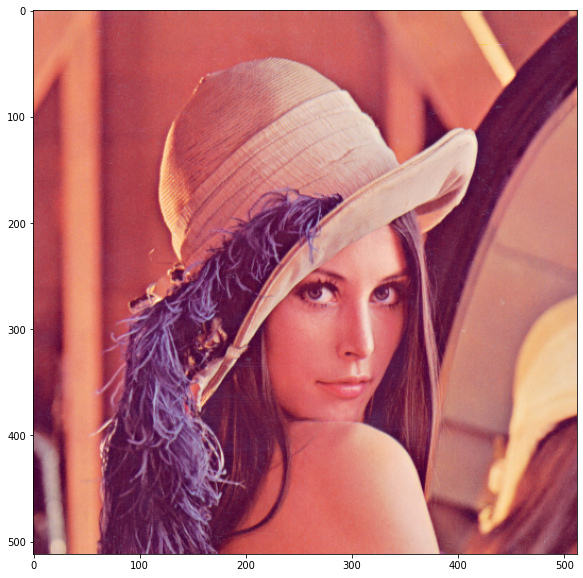

In [2]:
img_recadree = cv2.imread('images/img_lena.png')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_recadree, cv2.COLOR_BGR2RGB))

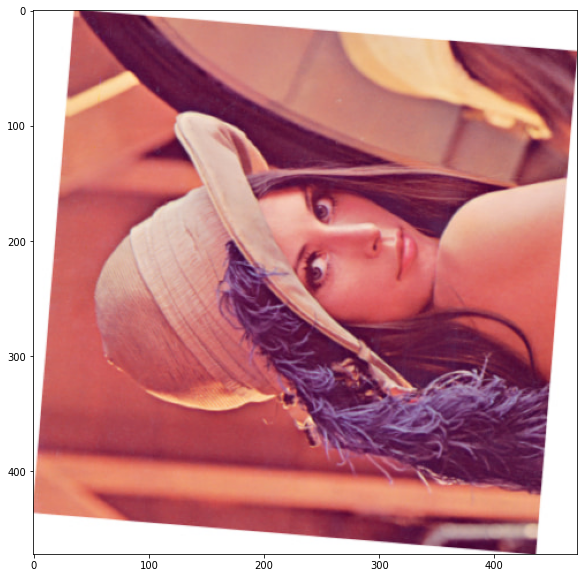

In [3]:
img_modifiee = cv2.imread('images/img_modifiee.jpg')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_modifiee, cv2.COLOR_BGR2RGB))

# Affichage des points d'intérêts (keypoints)

Pour chacune de ces images, nous avons d'abord affiché les points d'intérêts.

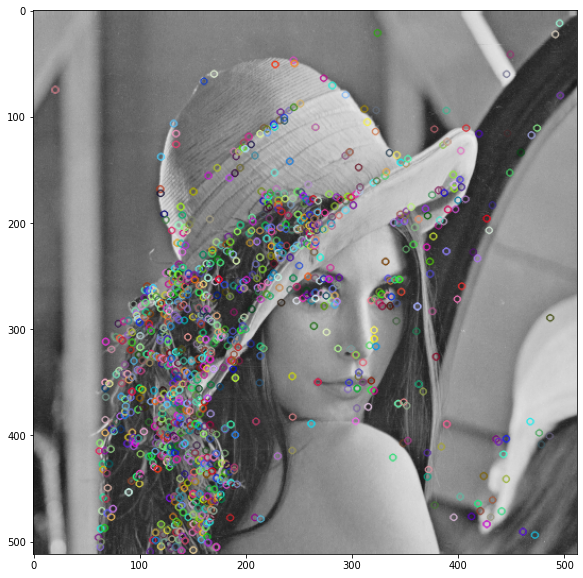

In [4]:
gray_r= cv2.cvtColor(img_recadree,cv2.COLOR_BGR2GRAY) # Convertit en nuances de gris

sift = cv2.SIFT_create() # Création de l'objet sift

keypoints_r, descriptor_r = sift.detectAndCompute(gray_r,None)
# keypoints est la liste de points clés, descriptor est un tableau numérique de taille nombre_de_keypoints*128

img_r_avec_keypoints=cv2.drawKeypoints(gray_r,keypoints_r,img_recadree)

plt.figure(figsize=(10,10)) # Affichage
plt.imshow(img_r_avec_keypoints)

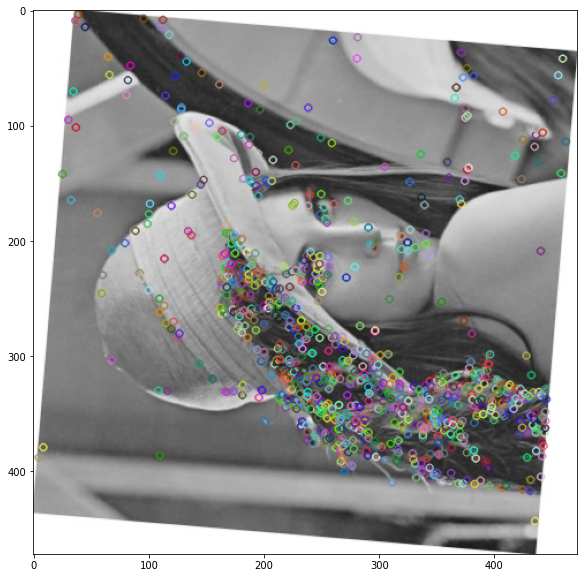

In [5]:
# Descripteur des keypoints
gray_m= cv2.cvtColor(img_modifiee,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

keypoints_m, descriptor_m = sift.detectAndCompute(gray_m,None)

img_m_avec_keypoints=cv2.drawKeypoints(gray_m,keypoints_m,img_modifiee)
 
plt.figure(figsize=(10,10)) # Affichage
plt.imshow(img_m_avec_keypoints)

Nous avons ensuite effectué un matching des descripteurs de ces deux images. 

Le matching est un matching de type Brute-Force disponible avec opencv.

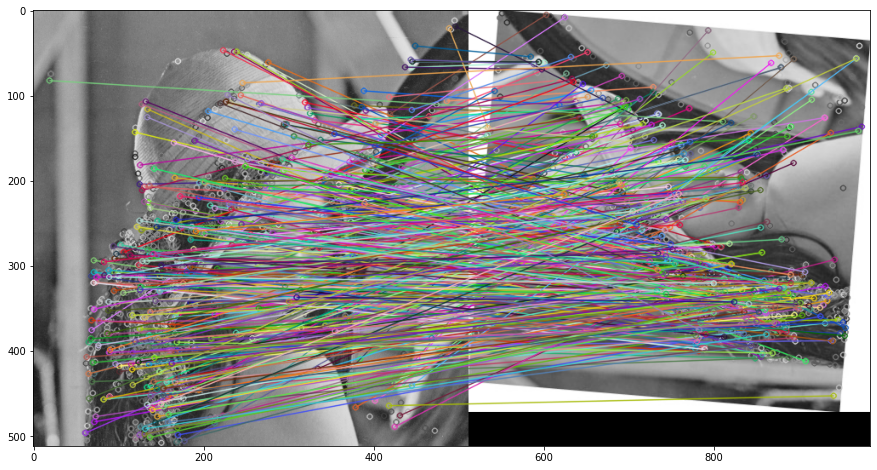

(<matplotlib.image.AxesImage at 0x7f61a4abeb10>, None)

In [6]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# Lecture
img1 = cv2.cvtColor(img_recadree, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img_modifiee, cv2.COLOR_BGR2GRAY)

# SIFT
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

# Matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches, img2, flags=2)
plt.figure(figsize=(15,15))
plt.imshow(img3),plt.show()

On affiche moins de matches dans le but de mieux les voir : 

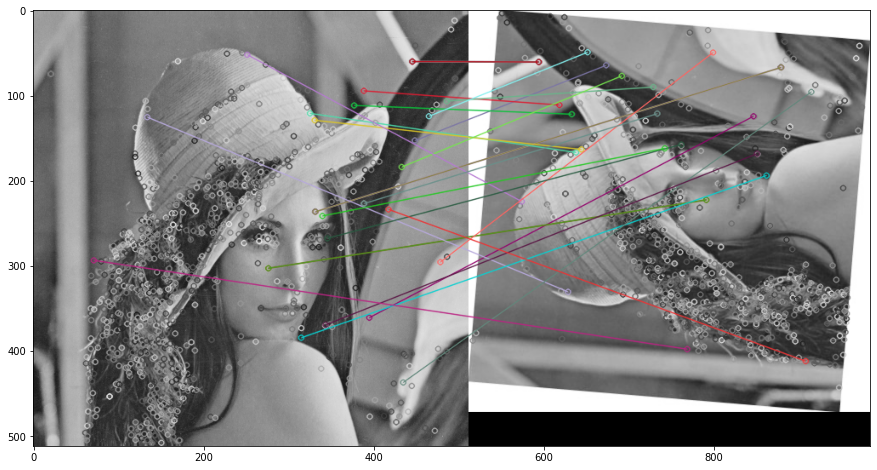

(<matplotlib.image.AxesImage at 0x7f61a48609d0>, None)

In [7]:
# Affichage avec moins de matches, sinon on voit bien moins bien

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:30], img2, flags=2)
plt.figure(figsize=(15,15))
plt.imshow(img3),plt.show()

On constate que la grande majorité des matchs sont corrects. Cela est le résultat attendu, le SIFT étant insensible au changement d'échelle et à la rotation.

Néanmoins, il reste quelques erreurs : par exemple, le match représenté en rouge en bas à droite de l'image de droite n'est pas correct. Cela est dû au fait que j'ai dû modifier plusieurs fois l'image, ce qui a occasionné des légères modifications au niveau de la pixelisation.

# II/ Détection d'objet dans un décor

## Le jeu Uncharted

Nous avons ensuite effectué une détection d'objets dans un décor. 

L'image d'entrainement est l'image ci-dessous du jeu vidéo Uncharted.

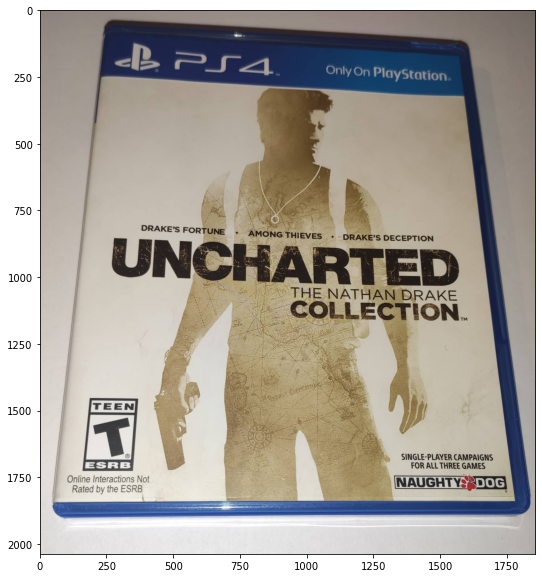

In [8]:
# Import et affichage de l'image d'entrainement: Jeu Uncharted

uncharted = cv2.imread('images/uncharted.jpg')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(uncharted, cv2.COLOR_BGR2RGB))

L'image requête est l'image ci-dessous du jeu Uncharted dans un décor.

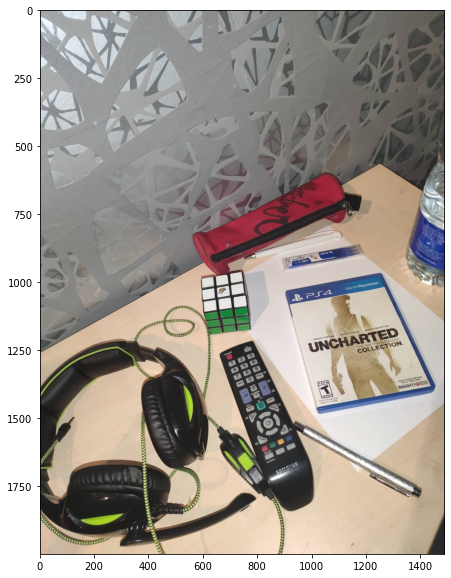

In [9]:
# Import et affichage d'une photo du jeu Uncharted dans un décor
uncharted_decor = cv2.imread('images/uncharted_decor.jpg')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(uncharted_decor, cv2.COLOR_BGR2RGB))

On effectue ensuite un matching entre les descripteurs des deux images. On utilise cette fois la librairie Flann (Fast Library for Approximate Nearest Neighbors) et on utilise la méthode des plus proches voisin (knn).

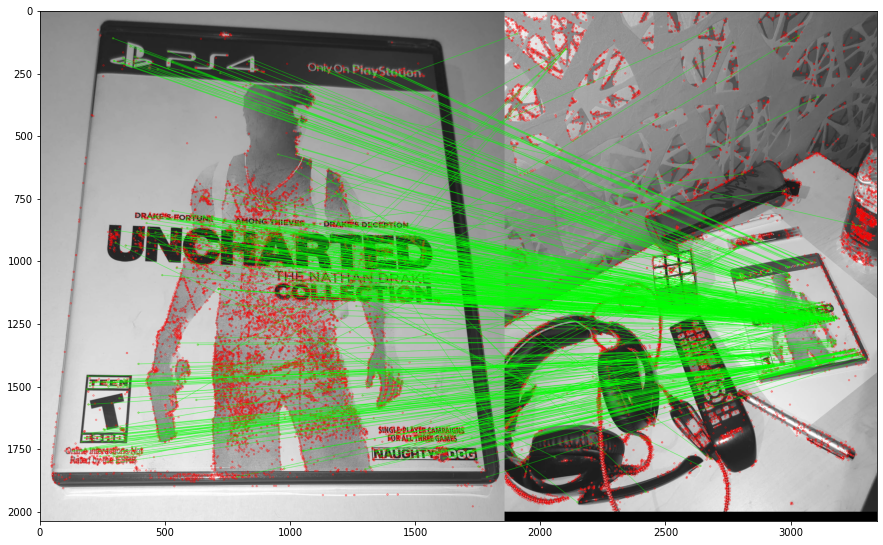

(<matplotlib.image.AxesImage at 0x7f61a481ba90>, None)

In [10]:
img1 = cv2.imread('images/uncharted.jpg',cv2.IMREAD_GRAYSCALE)       # Import de l'image d'entrainement
img2 = cv2.imread('images/uncharted_decor.jpg',cv2.IMREAD_GRAYSCALE) # Import de l'image requête
# Initiation de l'objet sift
sift = cv2.SIFT_create()

# Calcul des keypoints et du descripteur
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# Paramètres FLANN (Fast Library for Approximate Nearest Neighbors) : c'est pour faire le match
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   


# On utilise ici la méthode des K plus proches voisins (KNN qu'on a pu voir en cours d'IML)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Masque pour les matchs jugés corrects
matchesMask = [[0,0] for i in range(len(matches))]


for i,(m,n) in enumerate(matches):
    
    if m.distance < 0.7*n.distance: # Critère pour considérer qu'un match est correct
        matchesMask[i]=[1,0] # On modifie le masque lorsque le match est correct
        
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)


img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

# Affichage

plt.figure(figsize=(15,15))
plt.imshow(img3,),plt.show()

Le matching entre les points d'intérêts de l'image d'entrainement et de l'objet dans l'image requête est concluant : la grande majorité des matches sont entre des points d'intérêts de l'image d'entraînement avec l'objet dans l'image requête.


Néanmoins, avant d'arriver à ce résultat concluant, j'ai réalisé d'autres expériences moins concluantes. Je tenais à les présenter pour montrer la démarche avec laquelle je suis arrivé à ce résultat concluant.

## Les expériences du rubixcube et de l'album

Ces expériences ont été effectuées avant ce que je viens de présenter sur le jeu Uncharted. Elles ont été relativement infructueuses, je les montre dans le but de montrer des limites et présenter ma démarche pour arriver à un résultat satisfaisant.

## L'expérience du rubixcube

Ce fut ma toute première expérience de reconnaissance d'objet : l'image d'entrainement est l'image d'un rubixcube présente ci-dessous.

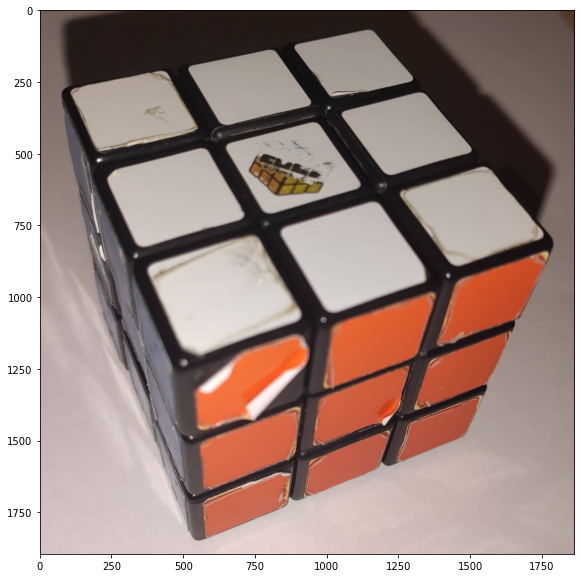

In [11]:
# Image rubixcube

img_rubixcube = cv2.imread('images/rubixcube.jpg')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_rubixcube, cv2.COLOR_BGR2RGB))

Ci dessous l'image du rubixcube dans un décor : l'image requête :

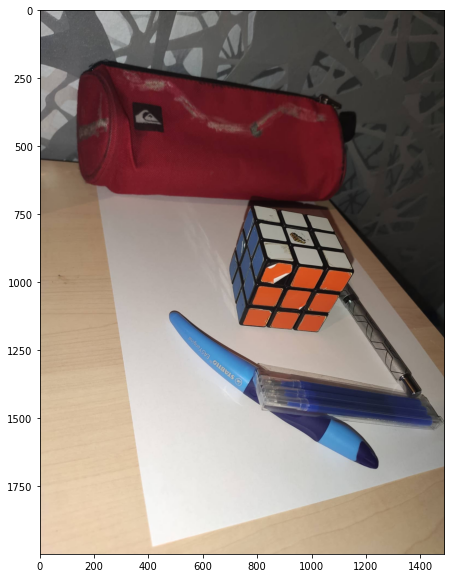

In [12]:
# Image rubixcube dans le décor
img_paysage_rubixcube = cv2.imread('images/paysage_rubixcube.jpg')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_paysage_rubixcube, cv2.COLOR_BGR2RGB))

Affichage des points d'intérêts de l'image d'entrainement : 

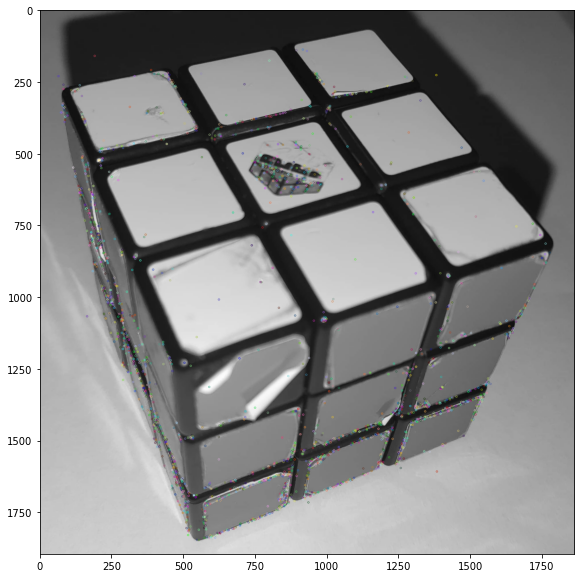

In [13]:
# Descripteur des keypoints
gray_r= cv2.cvtColor(img_rubixcube,cv2.COLOR_BGR2GRAY) # Convertit en nuances de gris

sift = cv2.SIFT_create() # Création de l'objet sift

keypoints_r, descriptor_r = sift.detectAndCompute(gray_r,None)
# keypoints est la liste de points clés, descriptor est un tableau numérique de taille nombre_de_keypoints*128

img_r_avec_keypoints=cv2.drawKeypoints(gray_r,keypoints_r,img_recadree)

plt.figure(figsize=(10,10)) # Affichage
plt.imshow(img_r_avec_keypoints)

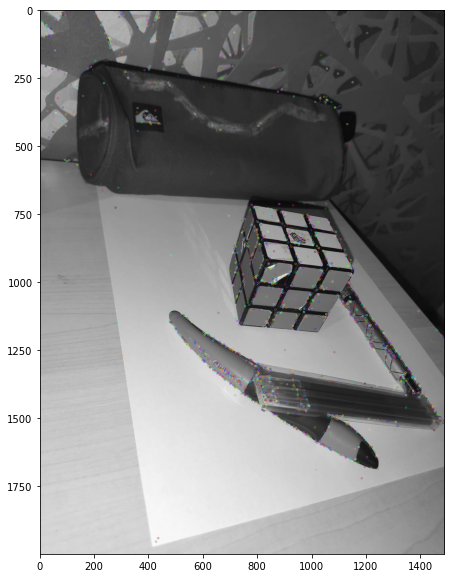

In [14]:
# Descripteur des keypoints
gray_r= cv2.cvtColor(img_paysage_rubixcube,cv2.COLOR_BGR2GRAY) # Convertit en nuances de gris

sift = cv2.SIFT_create() #création de l'objet sift

keypoints_r, descriptor_r = sift.detectAndCompute(gray_r,None)
# keypoints est la liste de points clés, descriptor est un tableau numérique de taille nombre_de_keypoints*128

img_r_avec_keypoints=cv2.drawKeypoints(gray_r,keypoints_r,img_recadree)

# Affichage
plt.figure(figsize=(10,10)) 
plt.imshow(img_r_avec_keypoints)

Matching entre les deux descripteurs : 

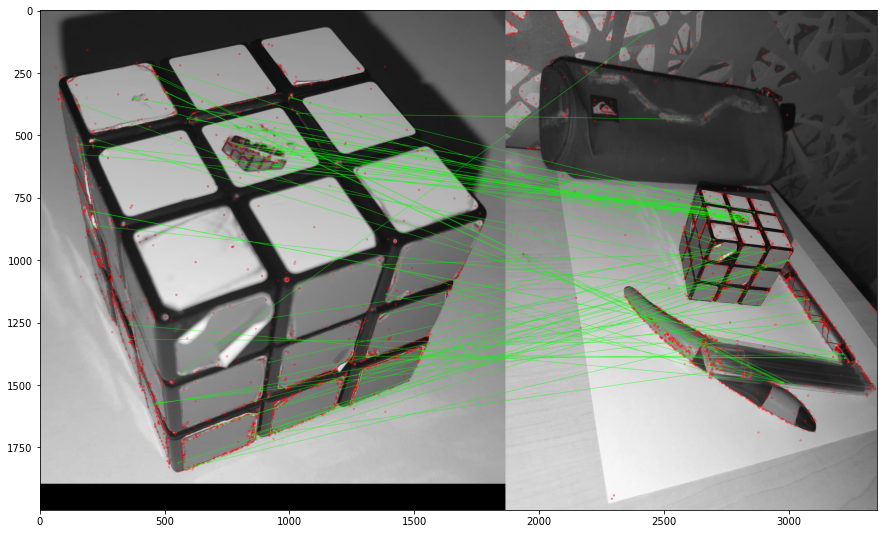

(<matplotlib.image.AxesImage at 0x7f61a45e44d0>, None)

In [15]:
img1 = cv2.imread('images/rubixcube.jpg',cv2.IMREAD_GRAYSCALE)         # Import de l'image d'entrainement
img2 = cv2.imread('images/paysage_rubixcube.jpg',cv2.IMREAD_GRAYSCALE) # Import de l'image requête
# Initiation de l'objet sift
sift = cv2.SIFT_create()

# Calcul des keypoints et du descripteur
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# Paramètres FLANN (Fast Library for Approximate Nearest Neighbors) : c'est pour faire le match
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   


# On utilise ici la méthode des K plus proches voisins (KNN qu'on a pu voir en cours d'IML)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Masque pour les matchs jugés corrects
matchesMask = [[0,0] for i in range(len(matches))]


for i,(m,n) in enumerate(matches):
    
    if m.distance < 0.7*n.distance: # Critère pour considérer qu'un match est correct
        matchesMask[i]=[1,0] # On modifie le masque lorsque le matche est correct
        
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)


img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

# Affichage

plt.figure(figsize=(15,15))
plt.imshow(img3,),plt.show()

Le bilan de l'expérience est mitigé : la part de matches de l'image d'entrainement avec l'objet lui-même n'est pas sensiblement supérieur au nombre de matches par rapport aux autres objets.

J'ai donc changé d'objet et choisi l'album de musique

# L'expérience de l'album de musique

J'effectue exactement la même démarche

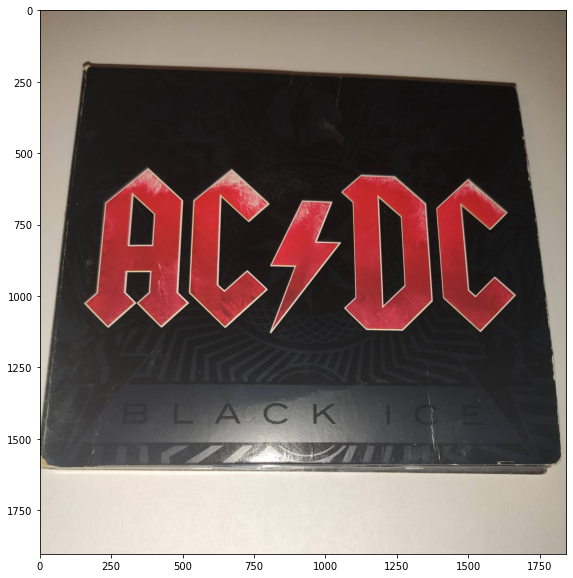

In [16]:
img_acdc_2 = cv2.imread('images/acdc_2.jpg')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_acdc_2, cv2.COLOR_BGR2RGB))

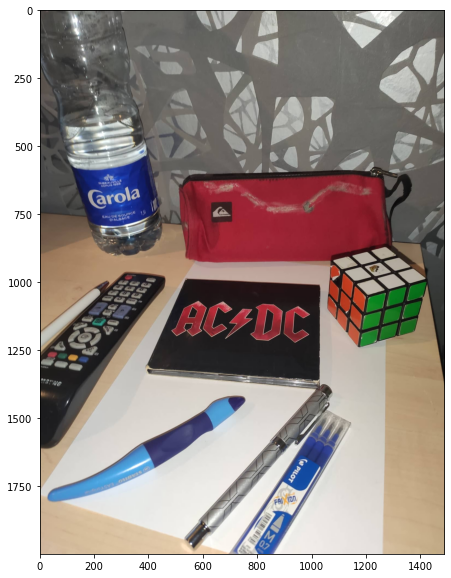

In [17]:
img_acdc = cv2.imread('images/acdc_dans_decor.jpg')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_acdc, cv2.COLOR_BGR2RGB))

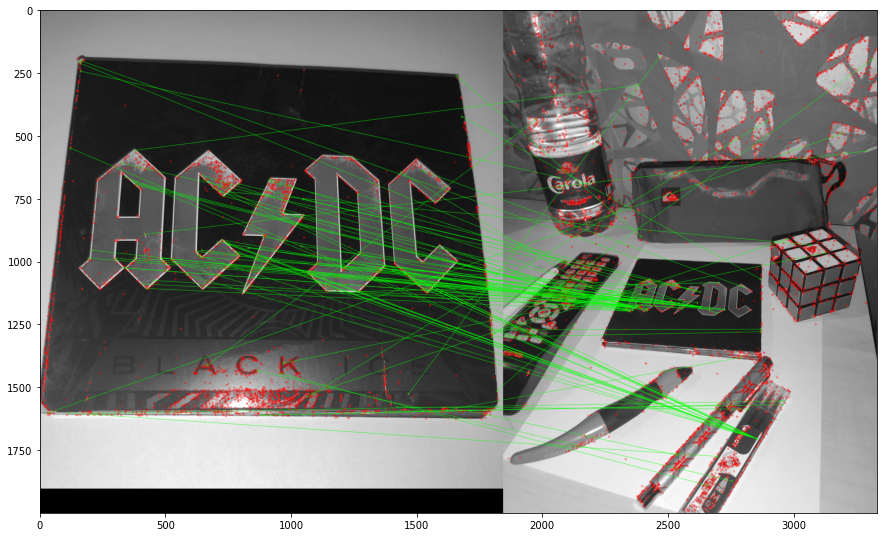

(<matplotlib.image.AxesImage at 0x7f61a412c390>, None)

In [18]:
img1 = cv2.imread('images/acdc_2.jpg',cv2.IMREAD_GRAYSCALE)          # Import de l'image d'entrainement
img2 = cv2.imread('images/acdc_dans_decor.jpg',cv2.IMREAD_GRAYSCALE) # Import de l'image requête
# Initiation de l'objet sift
sift = cv2.SIFT_create()

# Calcul des keypoints et du descripteur
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# Paramètres FLANN (Fast Library for Approximate Nearest Neighbors) : c'est pour faire le match
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   


# On utilise ici la méthode des K plus proches voisins (KNN qu'on a pu voir en cours d'IML)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Masque pour les matchs jugés corrects
matchesMask = [[0,0] for i in range(len(matches))]


for i,(m,n) in enumerate(matches):
    
    if m.distance < 0.7*n.distance: # Critère pour considérer qu'un match est correct
        matchesMask[i]=[1,0] # On modifie le masque lorsque le matche est correct
        
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)


img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

# Affichage

plt.figure(figsize=(15,15))
plt.imshow(img3,),plt.show()

Le bilan est mitigé : des détails présents dans l'image d'entrainement ne sont pas présents dans l'objet de l'image requête. Le matcheur va essayer de matcher des points descripteurs non trouvés dans l'image requête avec d'autres objets de l'image requête, d'où un nombre conséquent d'erreurs en proportion 

Ces essais m'ont permis de sélectionner un objet pour des performances optimales.

# III/ Démonstration : détection en direct de l'objet uncharted 

Cela est l'aboutissement de la partie application. Nous avons, dans une boucle fait une acquisition vidéo de l'image requête en direct et effectué le matching en direct. Puis une polyligne est tracé autour de l'objet matché.

Attention : l'exécution de ce code activera la caméra. Si jamais vous voulez voir la détection en direct par vous même, vous pouvez par exemple mettre l'image du jeu Uncharted sur votre smartphone, cela marchera de manière semblable. Vous pouvez aussi essayer de mettre un autre jeu, et vous verrez que la polyligne n'apparaît pas.

/!\ Pour quitter la caméra, il faut appuyer sur la touche "q"

In [19]:
import time
import cv2
import numpy as np

seuil_nombre_de_match=10 # Seuil qui définit le nombre de matchs requis pour que l'on considère une détection

sift=cv2.SIFT_create() # Création de l'objet SIFT

FLANN_INDEX_KDITREE=0 
flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
flann=cv2.FlannBasedMatcher(flannParam,{}) # Initiaition d'un objet FLANN (Fast Library for Approximate Nearest Neighbors) pour le matching

img_uncharted=cv2.imread("images/uncharted.jpg",0) # Chargement de l'image d'entrainement : la photo du jeu uncharted

trainKP,trainDesc=sift.detectAndCompute(img_uncharted,None) # Calcul des keypoints et du descripteur 

video = cv2.VideoCapture(0) # Fenêtre vidéo


while(True): # On effectue cela en boucle
    
    ret, image_video_couleur=video.read() # On importe l'image requête
    
    image_video=cv2.cvtColor(image_video_couleur,cv2.COLOR_BGR2GRAY) # On convertit en gris
    queryKP,queryDesc=sift.detectAndCompute(image_video,None)
    
    
    matches=flann.knnMatch(queryDesc,trainDesc,k=2)  # Matching avec flann

    goodMatch=[]  # Cette liste contiendra les matchs jugés corrects
    
    
    for m,n in matches:
        if(m.distance<0.75*n.distance):
            goodMatch.append(m)
            
            
    if(len(goodMatch)>seuil_nombre_de_match): # On traite si on est supérieur au seuil
        tp=[]
        qp=[]
        
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        h,w=img_uncharted.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        
        cv2.polylines(image_video_couleur,[np.int32(queryBorder)],True,(0,255,0),5) # Contours verts
        
        print("Le jeu vidéo Uncharted a été trouvé !- %d/%d"%(len(goodMatch),seuil_nombre_de_match))
        
    else:
        print ("Le jeu vidéo Uncharted n'a pas été trouvé !- %d/%d"%(len(goodMatch),seuil_nombre_de_match))
        
    cv2.imshow('result',image_video_couleur)
    
    if cv2.waitKey(10)==ord('q'): # Condition d'arrêt
        break

        q
    
video.release()
cv2.destroyAllWindows()



Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10


Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 2/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 2/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 4/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 4/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 2/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 0/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10
Le jeu vidéo Uncharted n'a pas été trouvé !- 1/10


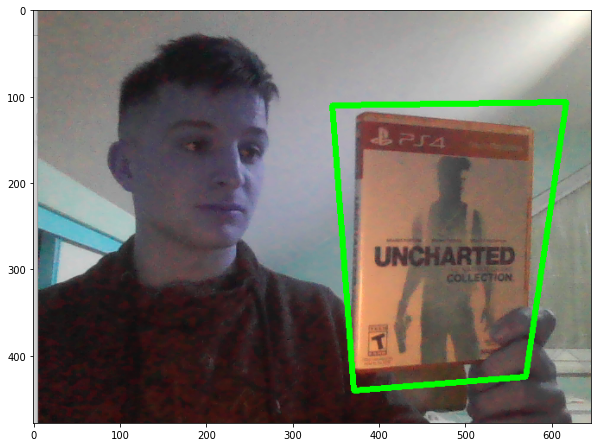

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.imread('images/capt_jeu_2.png'))

Cela fonctionne très bien : la polyligne suit en direct le jeu Uncharted. Le critère qui définit si l'objet est détecté ou non est la variable seuil_nombre_de_match, qui, certes est un seuil fixe défini arbitrairement, mais fonctionne efficacement.

Durant toutes ces applications, nous avons travaillé en nuances de gris. Cela semble être la norme sur python avec opencv : en effet, l'immense majorité des applications du SIFT que l'on peut trouver sur Internet se font en nuances de gris. Une proposition d'amélioration que l'on aurait pu apporter à ces modèles aurait été de travailler avec les 3 channels d'origine, pour avoir une détection plus efficace car nous n'aurions pas eu la perte d'information du passage de 3 channels à 1 channel.